In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ks_2samp
from joblib import dump

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df_data = pd.read_csv("./data/ML_Models/data3.csv")
df_data

,tendencia,DANE_DPTO_NOM,DANE_MUNI_NOM,COD_MUNICIPIO,ALF_Sabe_Leer_Norm,ALF_No_Sabe_Leer_Norm,ALF_SININF_Norm,EDAD_19_o_menor,EDAD_20-24_Norm,EDAD_25-29_Norm,...,SER_Internet_No_Norm,SER_Internet_Sin_informacion_Norm,SX_Hombre_Norm,SX_Mujer_Norm,TH_Pareja_joven_sin_hijos_Norm,TH_Etapa_inicial_Norm,TH_Etapa_de_expansion__Norm,TH_Etapa_de_consolidacion__Norm,TH_Etapa_de_salida__Norm,TH_Pareja_mayor_sin_hijos_Norm
0,Derecha,ANTIOQUIA,MEDELLIN,5001,0.9642,0.0232,0.0125,0.2488,0.0956,0.0939,...,0.3297,0.0078,0.4701,0.5299,0.0661,0.0897,0.1318,0.2435,0.3718,0.0971
1,Derecha,ANTIOQUIA,ABEJORRAL,5002,0.8929,0.1009,0.0062,0.2929,0.0700,0.0616,...,0.8071,0.0015,0.5193,0.4807,0.0455,0.0782,0.1517,0.2859,0.2706,0.1682
2,Derecha,ANTIOQUIA,ABRIAQUI,5004,0.9203,0.0698,0.0100,0.2997,0.0815,0.0579,...,0.8930,0.0041,0.5424,0.4576,0.0266,0.0949,0.1404,0.3074,0.2657,0.1651
3,Derecha,ANTIOQUIA,ALEJANDRIA,5021,0.9054,0.0852,0.0094,0.3071,0.0685,0.0667,...,0.8592,0.0051,0.4980,0.5020,0.0455,0.0789,0.1741,0.2804,0.2470,0.1741
4,Derecha,ANTIOQUIA,AMAGA,5030,0.9213,0.0754,0.0033,0.2732,0.0865,0.0852,...,0.7491,0.0017,0.4937,0.5063,0.0564,0.0884,0.1429,0.2594,0.3225,0.1304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,Derecha,VAUPES,YAVARATE,97889,0.8409,0.0909,0.0682,0.7169,0.0489,0.0278,...,0.8065,0.1720,0.5212,0.4788,0.0139,0.0694,0.1250,0.5417,0.2083,0.0417
1118,Derecha,VICHADA,PUERTO CARRENO,99001,0.8826,0.1021,0.0153,0.4142,0.1020,0.0854,...,0.8566,0.0143,0.5267,0.4733,0.0766,0.1586,0.2119,0.3064,0.1560,0.0906
1119,Derecha,VICHADA,SANTA ROSALIA,99624,0.9127,0.0789,0.0084,0.4529,0.0859,0.0713,...,0.9637,0.0010,0.5261,0.4739,0.0686,0.1430,0.2258,0.2991,0.1631,0.1005
1120,Izquierda,VICHADA,CUMARIBO,99773,0.8314,0.1403,0.0283,0.5595,0.0920,0.0682,...,0.9489,0.0401,0.5328,0.4672,0.0742,0.2008,0.2237,0.3724,0.0690,0.0599


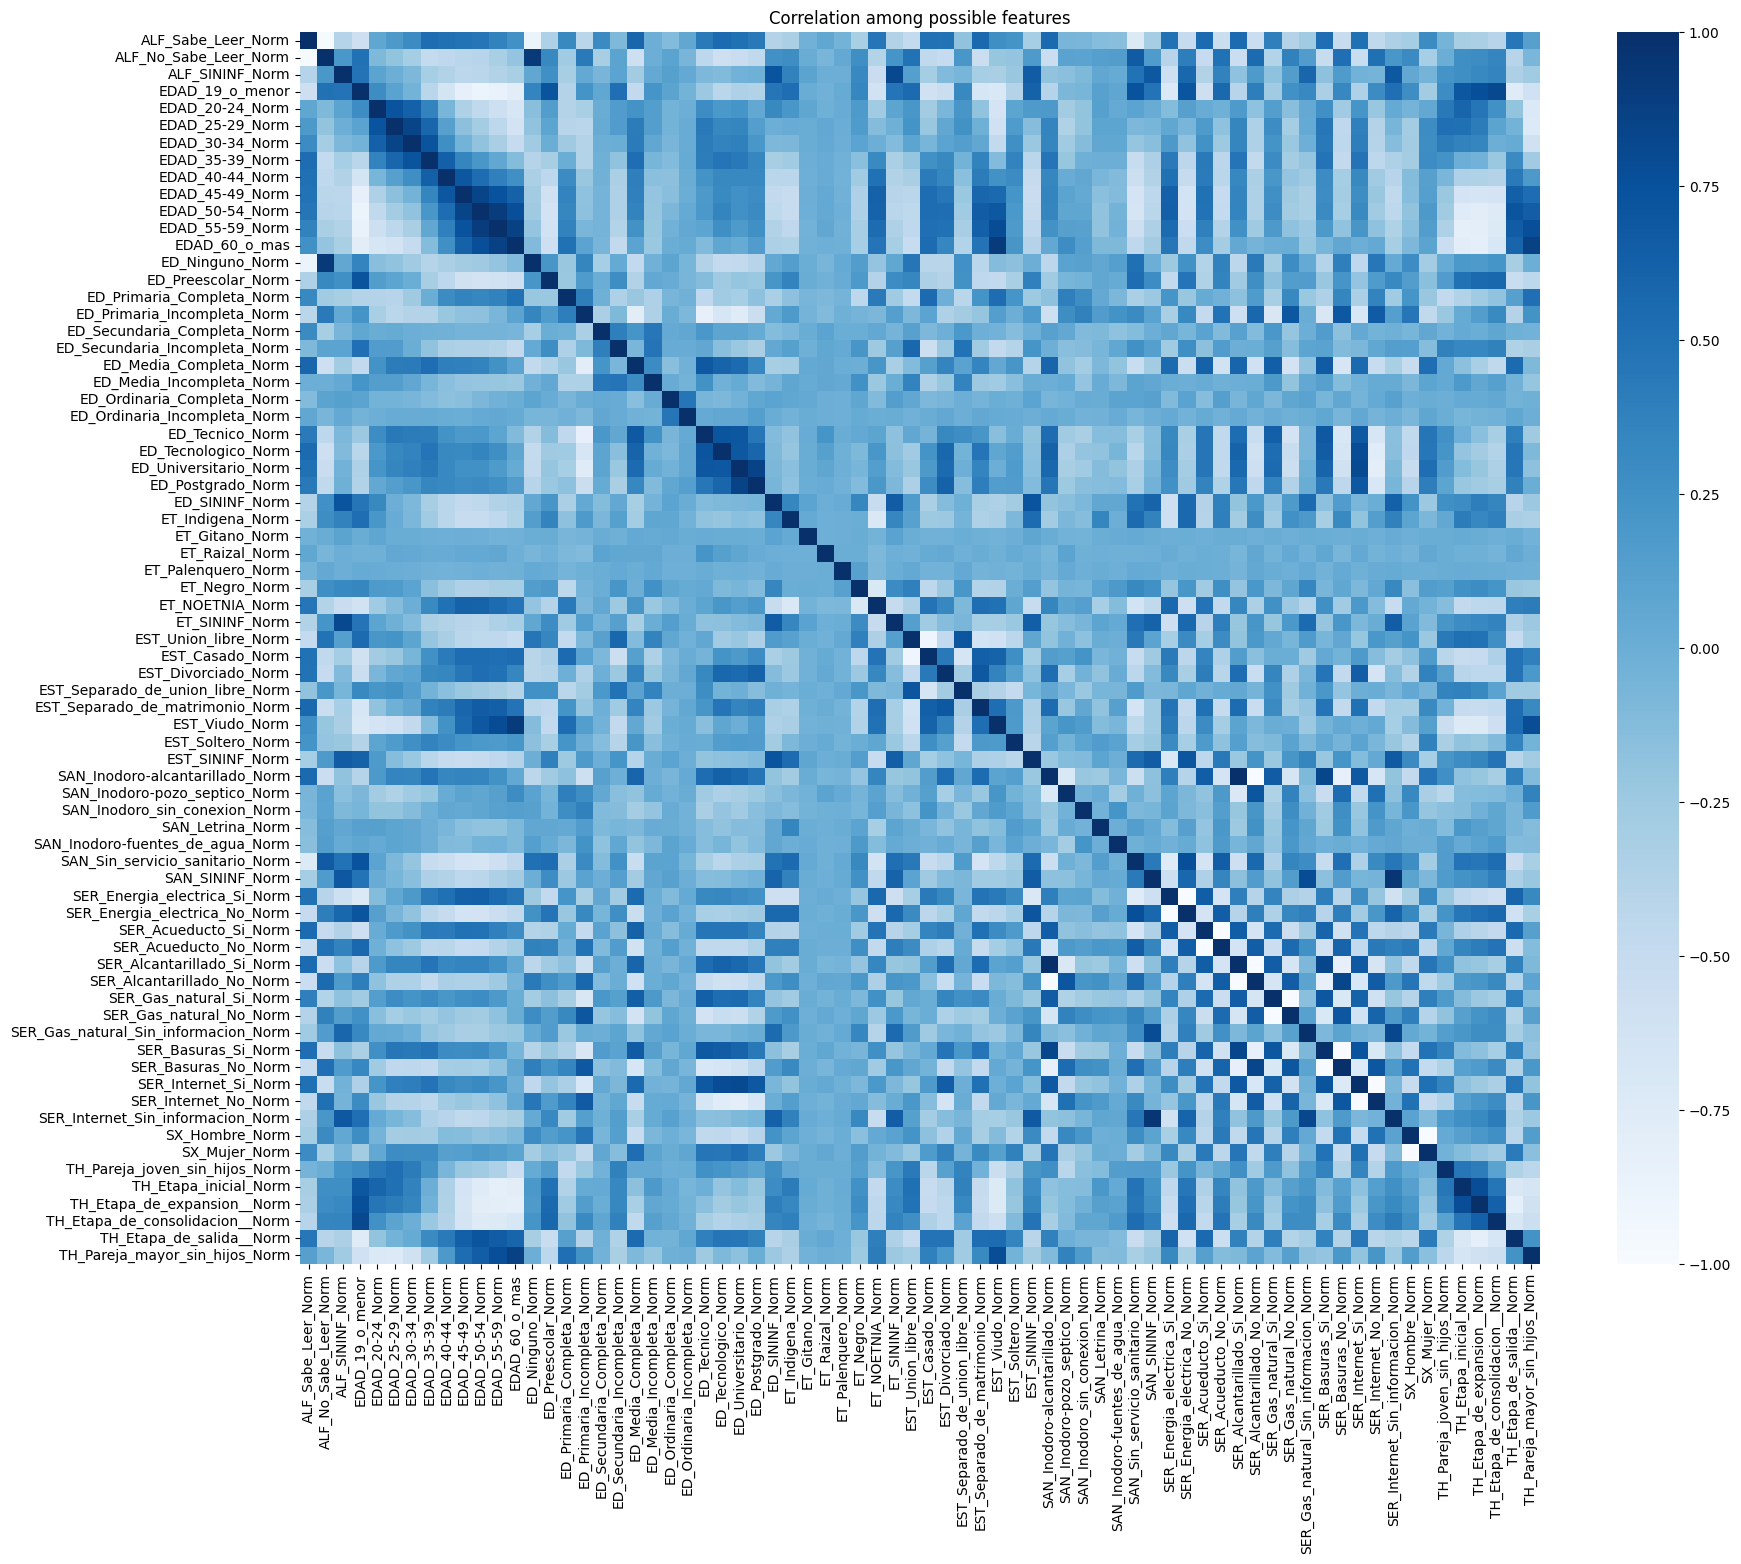

In [3]:
col = df_data.columns
features = col[4:84]

plt.figure(figsize=(20, 16))
sns.heatmap(
    df_data[features].corr(),
    cmap="Blues"
)
plt.title("Correlation among possible features")
plt.show()

In [4]:
# Reducción de variables mas correlacionadas linealmente

cor = df_data[features].corr()
th = 0.90
high_cor = np.where(np.abs(cor) > th)
high_cor_feats = set()

for i in range(len(high_cor[0])):
    if high_cor[0][i] != high_cor [1][i] and high_cor[0][i] not in high_cor_feats:
        feat1 = df_data.columns[high_cor[0][i]]
        feat2 = df_data.columns[high_cor[1][i]]
        high_cor_feats.add(feat2)

filtered_df = df_data.drop(columns=high_cor_feats)

In [5]:
# Reducción de features usando KS Test
ks_results = []
for f in filtered_df.columns:
    ks_stat, p_value = ks_2samp(df_data.loc[df_data["tendencia"] == "Izquierda", f], df_data.loc[df_data["tendencia"] == "Derecha", f])
    ks_results.append({
        "Feature": f,
        "KS stat": ks_stat,
        "p-value": p_value
    })
ks_feats = pd.DataFrame(ks_results).sort_values(by="KS stat",ascending=False)

In [6]:
ks_feats["KS stat"].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.95])

count    52.000000
mean      0.204159
std       0.106912
min       0.030987
5%        0.060061
10%       0.109086
25%       0.134476
50%       0.180769
75%       0.249149
95%       0.403134
max       0.504744
Name: KS stat, dtype: float64

In [7]:
Q10 = ks_feats["KS stat"].describe(percentiles=[0.1])["10%"]

In [22]:
# Creación de datasets de entrenamiento y prueba

features = ks_feats.loc[ks_feats["KS stat"]>=Q10]["Feature"]
features = features.drop(index=1)
#features = ks_feats["Feature"].head(25)
df_data_x = filtered_df[features]
df_data_y = df_data["tendencia"]

x_train, x_test, y_train, y_test = train_test_split(df_data_x,df_data_y,stratify=df_data_y,test_size=0.30,random_state=0)

In [24]:
features.to_csv("./data/ML_Models/selected_variables.csv")

In [25]:
y_train

861       Derecha
88        Derecha
465       Derecha
1112    Izquierda
219     Izquierda
          ...    
369     Izquierda
408       Derecha
157       Derecha
1031    Izquierda
210     Izquierda
Name: tendencia, Length: 785, dtype: object

In [26]:
x_train.describe()

,ET_NOETNIA_Norm,EDAD_20-24_Norm,EST_Viudo_Norm,ET_Indigena_Norm,TH_Pareja_mayor_sin_hijos_Norm,EDAD_55-59_Norm,ED_Primaria_Completa_Norm,EDAD_50-54_Norm,EDAD_25-29_Norm,EDAD_60_o_mas,...,ED_Postgrado_Norm,SER_Internet_No_Norm,ALF_No_Sabe_Leer_Norm,ED_Media_Completa_Norm,ET_Raizal_Norm,ED_Ordinaria_Completa_Norm,ED_Preescolar_Norm,ED_Ninguno_Norm,SAN_Inodoro-pozo_septico_Norm,ED_Universitario_Norm
count,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,...,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000,785.000000
mean,0.836235,0.080522,0.043405,0.076251,0.141855,0.049782,0.151935,0.055799,0.072092,0.143417,...,0.010332,0.871600,0.093455,0.172319,0.001698,0.001456,0.024615,0.069717,0.367407,0.041163
std,0.291581,0.013418,0.014294,0.195997,0.050131,0.011760,0.034725,0.010827,0.011378,0.051184,...,0.008629,0.140101,0.047567,0.045688,0.034981,0.002546,0.008375,0.035306,0.203796,0.029649
min,0.002100,0.038900,0.008100,0.000000,0.026000,0.010600,0.072000,0.020700,0.027800,0.026100,...,0.000000,0.118000,0.010500,0.009500,0.000000,0.000000,0.006000,0.009900,0.004700,0.001000
25%,0.858500,0.073000,0.033400,0.000300,0.103900,0.041500,0.126200,0.049200,0.064900,0.105600,...,0.005600,0.845100,0.061200,0.143400,0.000000,0.000400,0.019100,0.045600,0.198100,0.023800
50%,0.981500,0.081700,0.042000,0.001400,0.132800,0.049600,0.152000,0.056500,0.073500,0.139000,...,0.008100,0.923700,0.086100,0.171300,0.000000,0.000800,0.023200,0.065500,0.342800,0.031500
75%,0.991000,0.088600,0.052500,0.028300,0.171400,0.057900,0.175900,0.064200,0.080100,0.174200,...,0.012200,0.957400,0.115100,0.199400,0.000100,0.001400,0.028700,0.087000,0.525000,0.048400
max,0.999100,0.250800,0.110200,0.985800,0.332600,0.088700,0.281700,0.082900,0.104100,0.333900,...,0.084400,0.992300,0.375500,0.386300,0.906500,0.029700,0.095100,0.366600,0.911900,0.227300


In [27]:
x_test.describe()

,ET_NOETNIA_Norm,EDAD_20-24_Norm,EST_Viudo_Norm,ET_Indigena_Norm,TH_Pareja_mayor_sin_hijos_Norm,EDAD_55-59_Norm,ED_Primaria_Completa_Norm,EDAD_50-54_Norm,EDAD_25-29_Norm,EDAD_60_o_mas,...,ED_Postgrado_Norm,SER_Internet_No_Norm,ALF_No_Sabe_Leer_Norm,ED_Media_Completa_Norm,ET_Raizal_Norm,ED_Ordinaria_Completa_Norm,ED_Preescolar_Norm,ED_Ninguno_Norm,SAN_Inodoro-pozo_septico_Norm,ED_Universitario_Norm
count,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,...,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000,337.000000
mean,0.860950,0.079259,0.044769,0.070499,0.145384,0.051057,0.149891,0.057093,0.071358,0.147964,...,0.011122,0.862617,0.094503,0.173232,0.000061,0.001356,0.024013,0.071885,0.353723,0.043482
std,0.267206,0.012245,0.014905,0.186388,0.050793,0.011483,0.032721,0.010999,0.011245,0.051194,...,0.011195,0.144424,0.047446,0.045140,0.000140,0.002245,0.007334,0.035074,0.194017,0.033036
min,0.002400,0.038200,0.006000,0.000000,0.036400,0.013500,0.063400,0.018000,0.036900,0.048200,...,0.000000,0.123500,0.008500,0.013500,0.000000,0.000000,0.010600,0.012500,0.008900,0.000000
25%,0.918200,0.071800,0.035100,0.000300,0.105700,0.043500,0.127700,0.050700,0.064800,0.112100,...,0.005600,0.836300,0.063200,0.138400,0.000000,0.000400,0.019200,0.048100,0.196900,0.023800
50%,0.982800,0.081000,0.043500,0.001400,0.137100,0.050600,0.150000,0.058500,0.072400,0.141000,...,0.008400,0.913000,0.086400,0.173100,0.000000,0.000800,0.022600,0.067400,0.326800,0.033900
75%,0.991800,0.087000,0.053700,0.024100,0.177400,0.059700,0.172000,0.065200,0.078300,0.187200,...,0.012300,0.951700,0.121900,0.204400,0.000100,0.001500,0.027300,0.090600,0.499900,0.050700
max,0.998600,0.119200,0.091400,0.976500,0.295500,0.077400,0.277300,0.084400,0.101700,0.316000,...,0.093100,0.993000,0.336500,0.304000,0.000900,0.019300,0.068900,0.240100,0.899700,0.235400


In [28]:
print("Valores únicos en el set de entrenamiento")
y_train.value_counts(dropna=False, normalize=True)

Valores únicos en el set de entrenamiento


tendencia
Derecha      0.756688
Izquierda    0.243312
Name: proportion, dtype: float64

In [29]:
print("Valores únicos en el set de prueba")
y_test.value_counts(dropna=False, normalize=True)

Valores únicos en el set de prueba


tendencia
Derecha      0.756677
Izquierda    0.243323
Name: proportion, dtype: float64

RANDOM FORREST

In [30]:
# Definición de Pipeline para el modelo.
# No requiere transformer ya que todas las variables son numéricas
pipeline = Pipeline([("classifier",  RandomForestClassifier(random_state=10))]) 

In [41]:
# Variables para iterar a través de GridSearchCV + Definición de F1 Score específico para Izquierda y Derecha

param_grid = {
    'classifier__n_estimators': [5, 10, 50, 100],
    #'classifier__n_estimators': [5, 10, 50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

f1_scorer = make_scorer(f1_score, pos_label="Izquierda")

grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                    scoring=f1_scorer, refit="f1", 
                    cv=5, return_train_score=True)

grid.fit(df_data_x, df_data_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=10))]),
             param_grid={'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [5, 10, 50, 100]},
             refit='f1', return_train_score=True,
             scoring=make_scorer(f1_score, pos_label=Izquierda))

In [42]:
def model(X):
    return grid.best_estimator_["classifier"].predict_proba(X)[:,1]

explainer = shap.Explainer(model, x_test)
shap_values = explainer(x_test)

PermutationExplainer explainer: 338it [01:11,  4.08it/s]                         


In [43]:
dump(grid,"./data/ML_Models/randomForestClassifier-v1.0.joblib")

['./data/ML_Models/randomForestClassifier-v1.0.joblib']

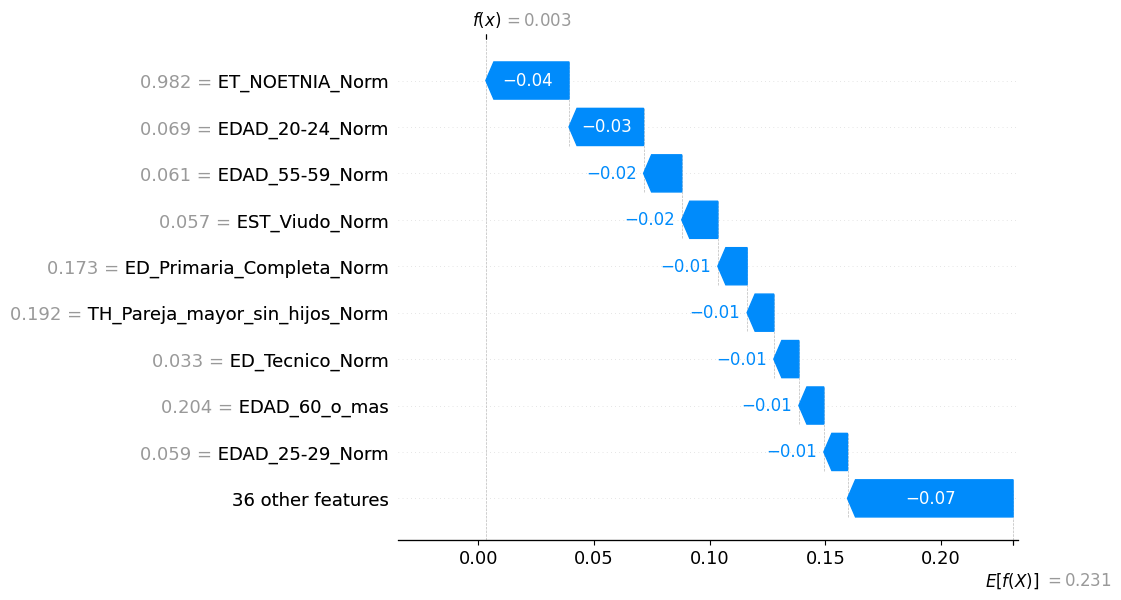

In [34]:
shap.plots.waterfall(shap_values[123])

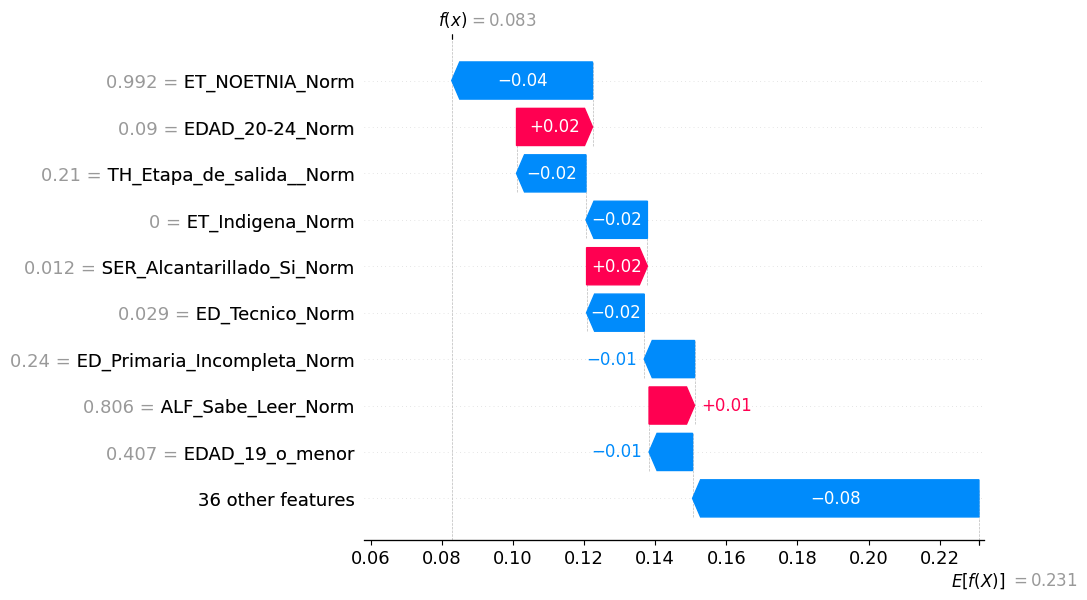

In [35]:
shap.plots.waterfall(shap_values[45])

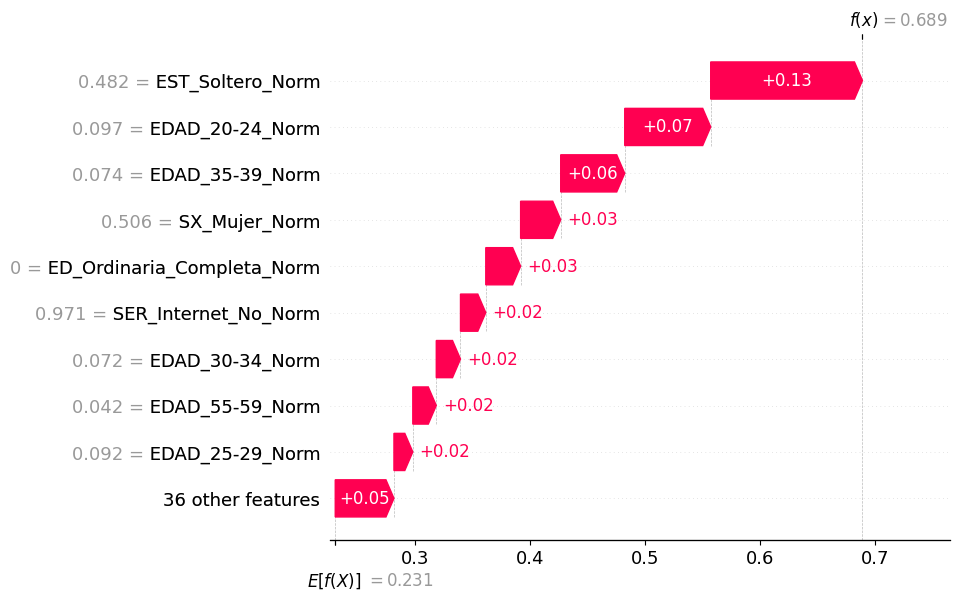

In [36]:
shap.plots.waterfall(shap_values[99])

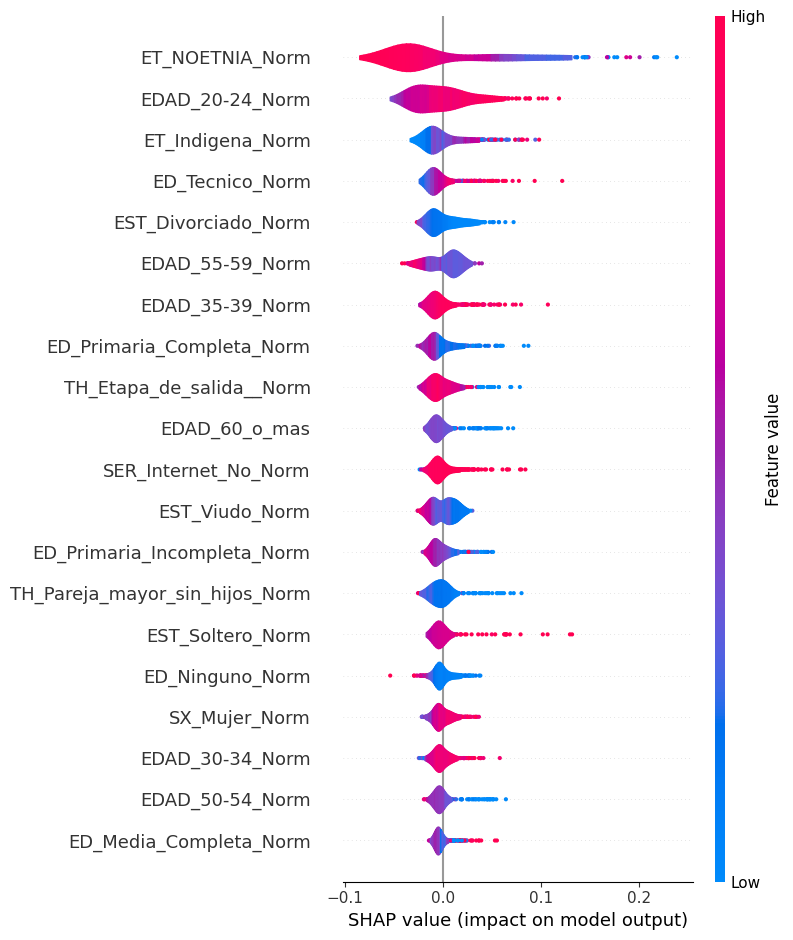

In [37]:
shap.summary_plot(shap_values, plot_type="violin")

In [38]:
print("Resultados para Random Forrest:")
print("Precision = ", precision_score(y_test,grid.predict(x_test),pos_label="Izquierda"))
print("Recall = ", recall_score(y_test,grid.predict(x_test),pos_label="Izquierda"))
print("F1 = ", f1_score(y_test,grid.predict(x_test),pos_label="Izquierda"))

Resultados para Random Forrest:
Precision =  1.0
Recall =  0.8536585365853658
F1 =  0.9210526315789475


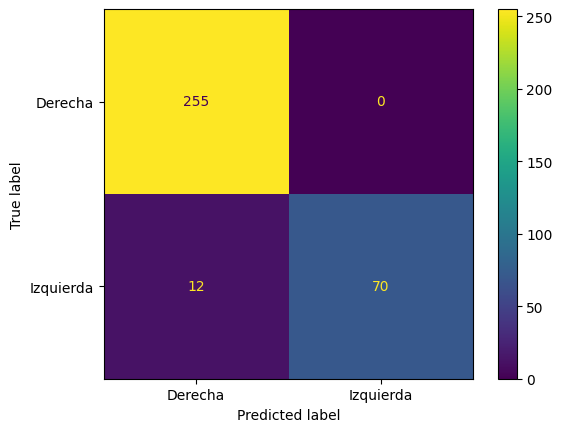

In [39]:
ConfusionMatrixDisplay.from_predictions(y_test, grid.predict(x_test))

LOGISTIC REGRESSION

In [37]:
# Definición de Pipeline para el modelo de regresion logisitca.
pipeline_LR = Pipeline([('logreg', LogisticRegression())])

In [38]:
# Variables para iterar a través de GridSearchCV + Definición de F1 Score específico para Izquierda y Derecha

param_grid = {
    'logreg__C': [0.1, 1, 10, 100],
    'logreg__penalty': ['l1','l2'],
    'logreg__solver': ['liblinear']
}

f1_scorer = make_scorer(f1_score, pos_label="Izquierda")

grid_LR = GridSearchCV(estimator=pipeline_LR, param_grid=param_grid, 
                    scoring=f1_scorer, refit="f1", 
                    cv=5, return_train_score=True)

grid_LR.fit(df_data_x, df_data_y)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.1, 1, 10, 100],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear']},
             refit='f1', return_train_score=True,
             scoring=make_scorer(f1_score, pos_label=Izquierda))

In [39]:
def model_LR(X):
    return grid_LR.best_estimator_["logreg"].predict_proba(X)[:,1]

explainer = shap.Explainer(model_LR, x_test)
shap_values = explainer(x_test)

PermutationExplainer explainer: 338it [00:11,  3.31it/s]                         


In [40]:
grid_LR.best_params_

{'logreg__C': 100, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}

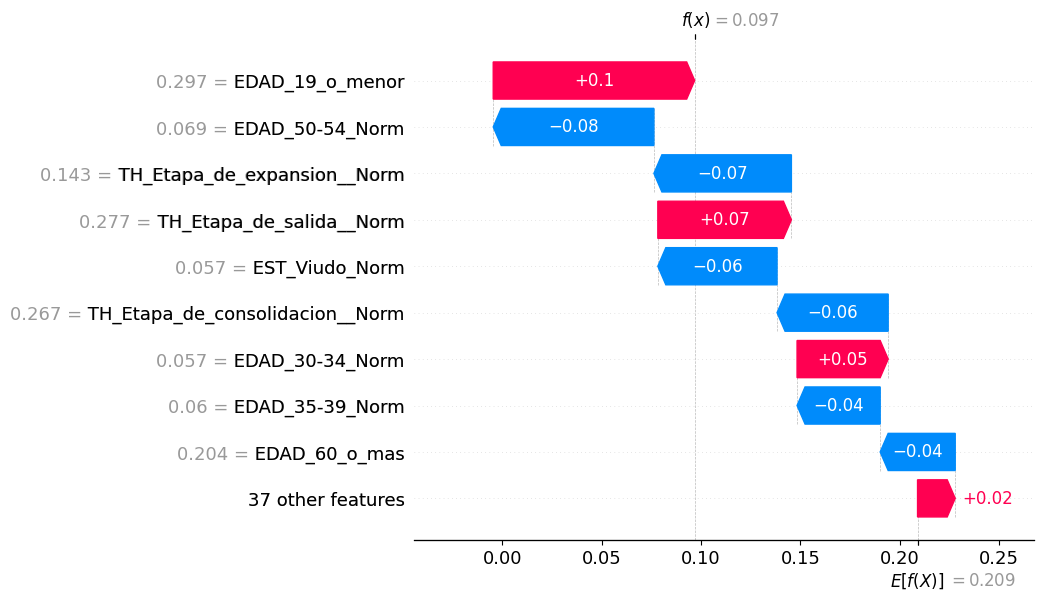

In [41]:
shap.plots.waterfall(shap_values[123])

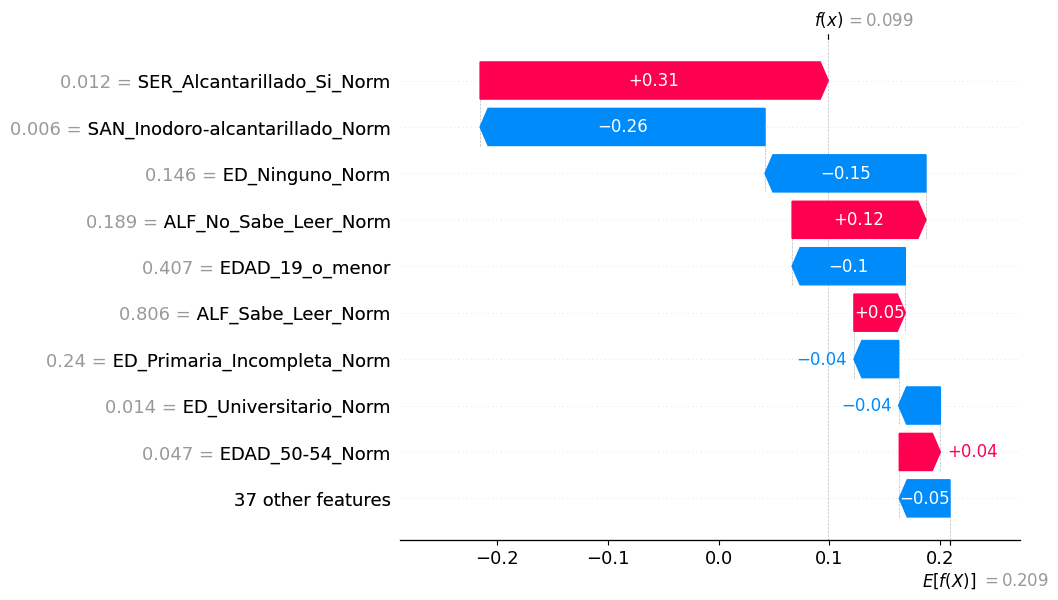

In [42]:
shap.plots.waterfall(shap_values[45])

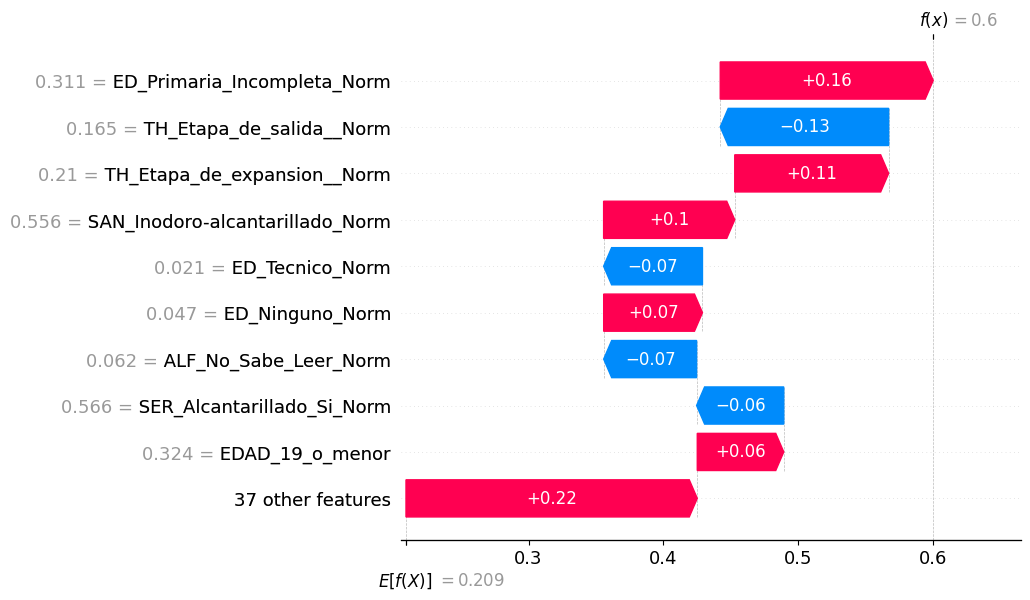

In [43]:
shap.plots.waterfall(shap_values[99])

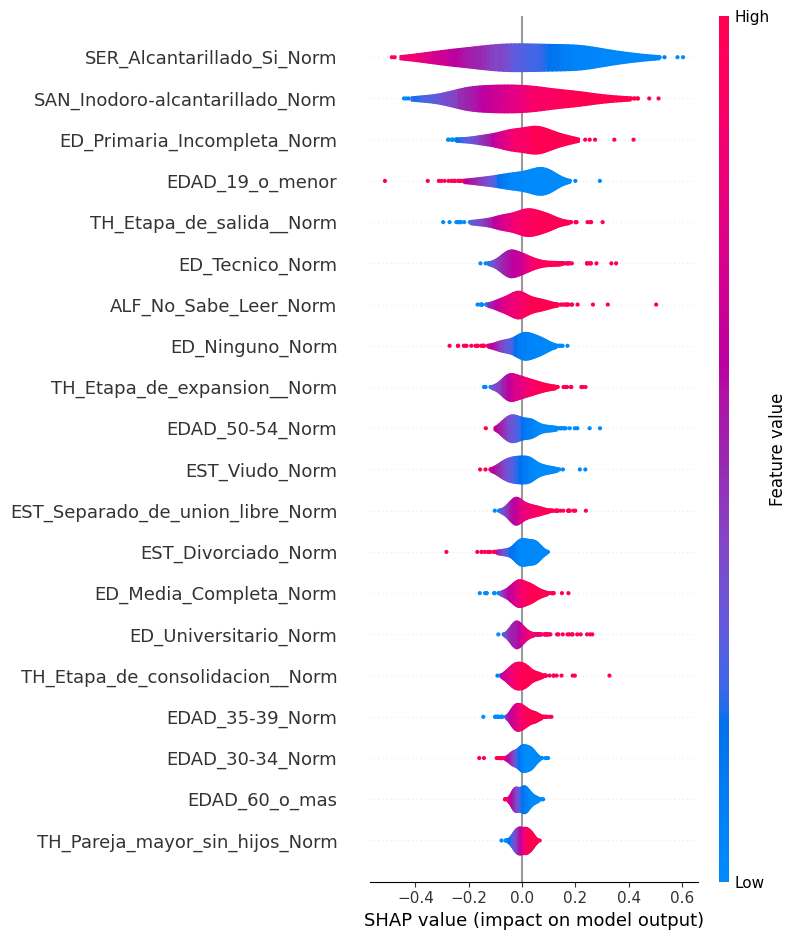

In [44]:
shap.summary_plot(shap_values, plot_type="violin")

In [45]:
print("Resultados para Logistic Regression:/n")
print("Precision = ", precision_score(y_test,grid_LR.predict(x_test),pos_label="Izquierda"))
print("Recall = ", recall_score(y_test,grid_LR.predict(x_test),pos_label="Izquierda"))
print("F1 = ", f1_score(y_test,grid_LR.predict(x_test),pos_label="Izquierda"))

Resultados para Logistic Regression:/n
Precision =  0.7627118644067796
Recall =  0.5487804878048781
F1 =  0.6382978723404256


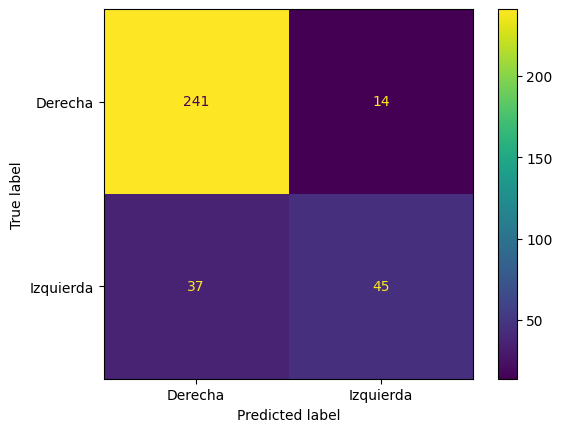

In [46]:
ConfusionMatrixDisplay.from_predictions(y_test, grid_LR.predict(x_test))

-----------------------------

Modelo Arbol de Decision

In [47]:
y_test.value_counts()

tendencia
Derecha      255
Izquierda     82
Name: count, dtype: int64

In [48]:
# Crea un modelo de árbol de decisión
clf = DecisionTreeClassifier()

# Entrena el modelo con los datos de entrenamiento
clf.fit(x_train,y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = clf.predict(x_test)

# Calcula la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.8338278931750742


In [49]:
predictions = clf.predict(x_test)

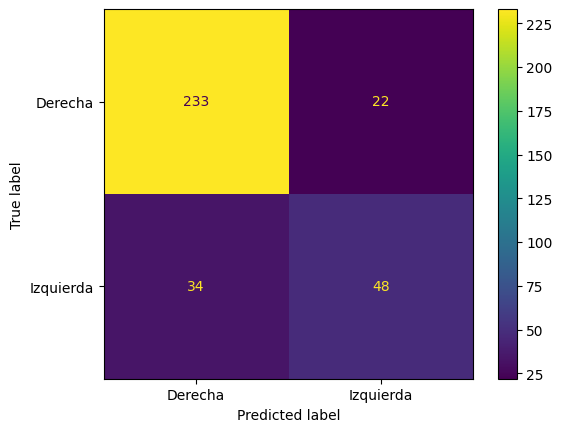

In [50]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions)

In [51]:
features = df_data_x.columns
features

Index(['ET_NOETNIA_Norm', 'EDAD_20-24_Norm', 'EST_Viudo_Norm',
       'ET_Indigena_Norm', 'TH_Pareja_mayor_sin_hijos_Norm', 'EDAD_55-59_Norm',
       'ED_Primaria_Completa_Norm', 'EDAD_50-54_Norm', 'EDAD_25-29_Norm',
       'EDAD_60_o_mas', 'TH_Etapa_inicial_Norm', 'EST_Divorciado_Norm',
       'EDAD_30-34_Norm', 'EST_Union_libre_Norm',
       'TH_Etapa_de_expansion__Norm', 'ALF_SININF_Norm',
       'TH_Etapa_de_salida__Norm', 'EDAD_19_o_menor', 'ED_SININF_Norm',
       'ET_SININF_Norm', 'EDAD_35-39_Norm', 'EST_SININF_Norm', 'SX_Mujer_Norm',
       'SX_Hombre_Norm', 'TH_Etapa_de_consolidacion__Norm', 'COD_MUNICIPIO',
       'ED_Tecnico_Norm', 'ED_Media_Incompleta_Norm', 'EST_Soltero_Norm',
       'SER_Internet_Sin_informacion_Norm', 'SAN_Inodoro-alcantarillado_Norm',
       'SER_Alcantarillado_Si_Norm', 'ED_Primaria_Incompleta_Norm',
       'EST_Separado_de_union_libre_Norm', 'ED_Tecnologico_Norm',
       'ALF_Sabe_Leer_Norm', 'ED_Postgrado_Norm', 'SER_Internet_No_Norm',
       'ALF_No

In [52]:
a =y_test.values

In [53]:
precision_score(a, predictions,pos_label="Izquierda")

0.6857142857142857

In [54]:
precision_score(a, predictions,pos_label="Derecha")

0.8726591760299626

In [55]:
# Calculating confusion matrix derived metrics
print("Precision:", precision_score(a, predictions,pos_label="Izquierda"))
print("Recall:", recall_score(a, predictions,pos_label="Izquierda"))
print("F1", f1_score(a, predictions,pos_label="Izquierda"))

Precision: 0.6857142857142857
Recall: 0.5853658536585366
F1 0.6315789473684211


In [56]:
# Calculating confusion matrix derived metrics
print("Precision:", precision_score(a, predictions,pos_label="Derecha"))
print("Recall:", recall_score(a, predictions,pos_label="Derecha"))
print("F1", f1_score(a, predictions,pos_label="Derecha"))

Precision: 0.8726591760299626
Recall: 0.9137254901960784
F1 0.89272030651341


Variando Parametros y Graficando las Decisiones

max_depth=3, criterion=gini: Mean Accuracy = 0.8114649681528663


max_depth=3, criterion=entropy: Mean Accuracy = 0.8152866242038217
max_depth=5, criterion=gini: Mean Accuracy = 0.8076433121019109
max_depth=5, criterion=entropy: Mean Accuracy = 0.7719745222929937
max_depth=7, criterion=gini: Mean Accuracy = 0.8000000000000002
max_depth=7, criterion=entropy: Mean Accuracy = 0.7949044585987262
max_depth=10, criterion=gini: Mean Accuracy = 0.7694267515923567
max_depth=10, criterion=entropy: Mean Accuracy = 0.78343949044586


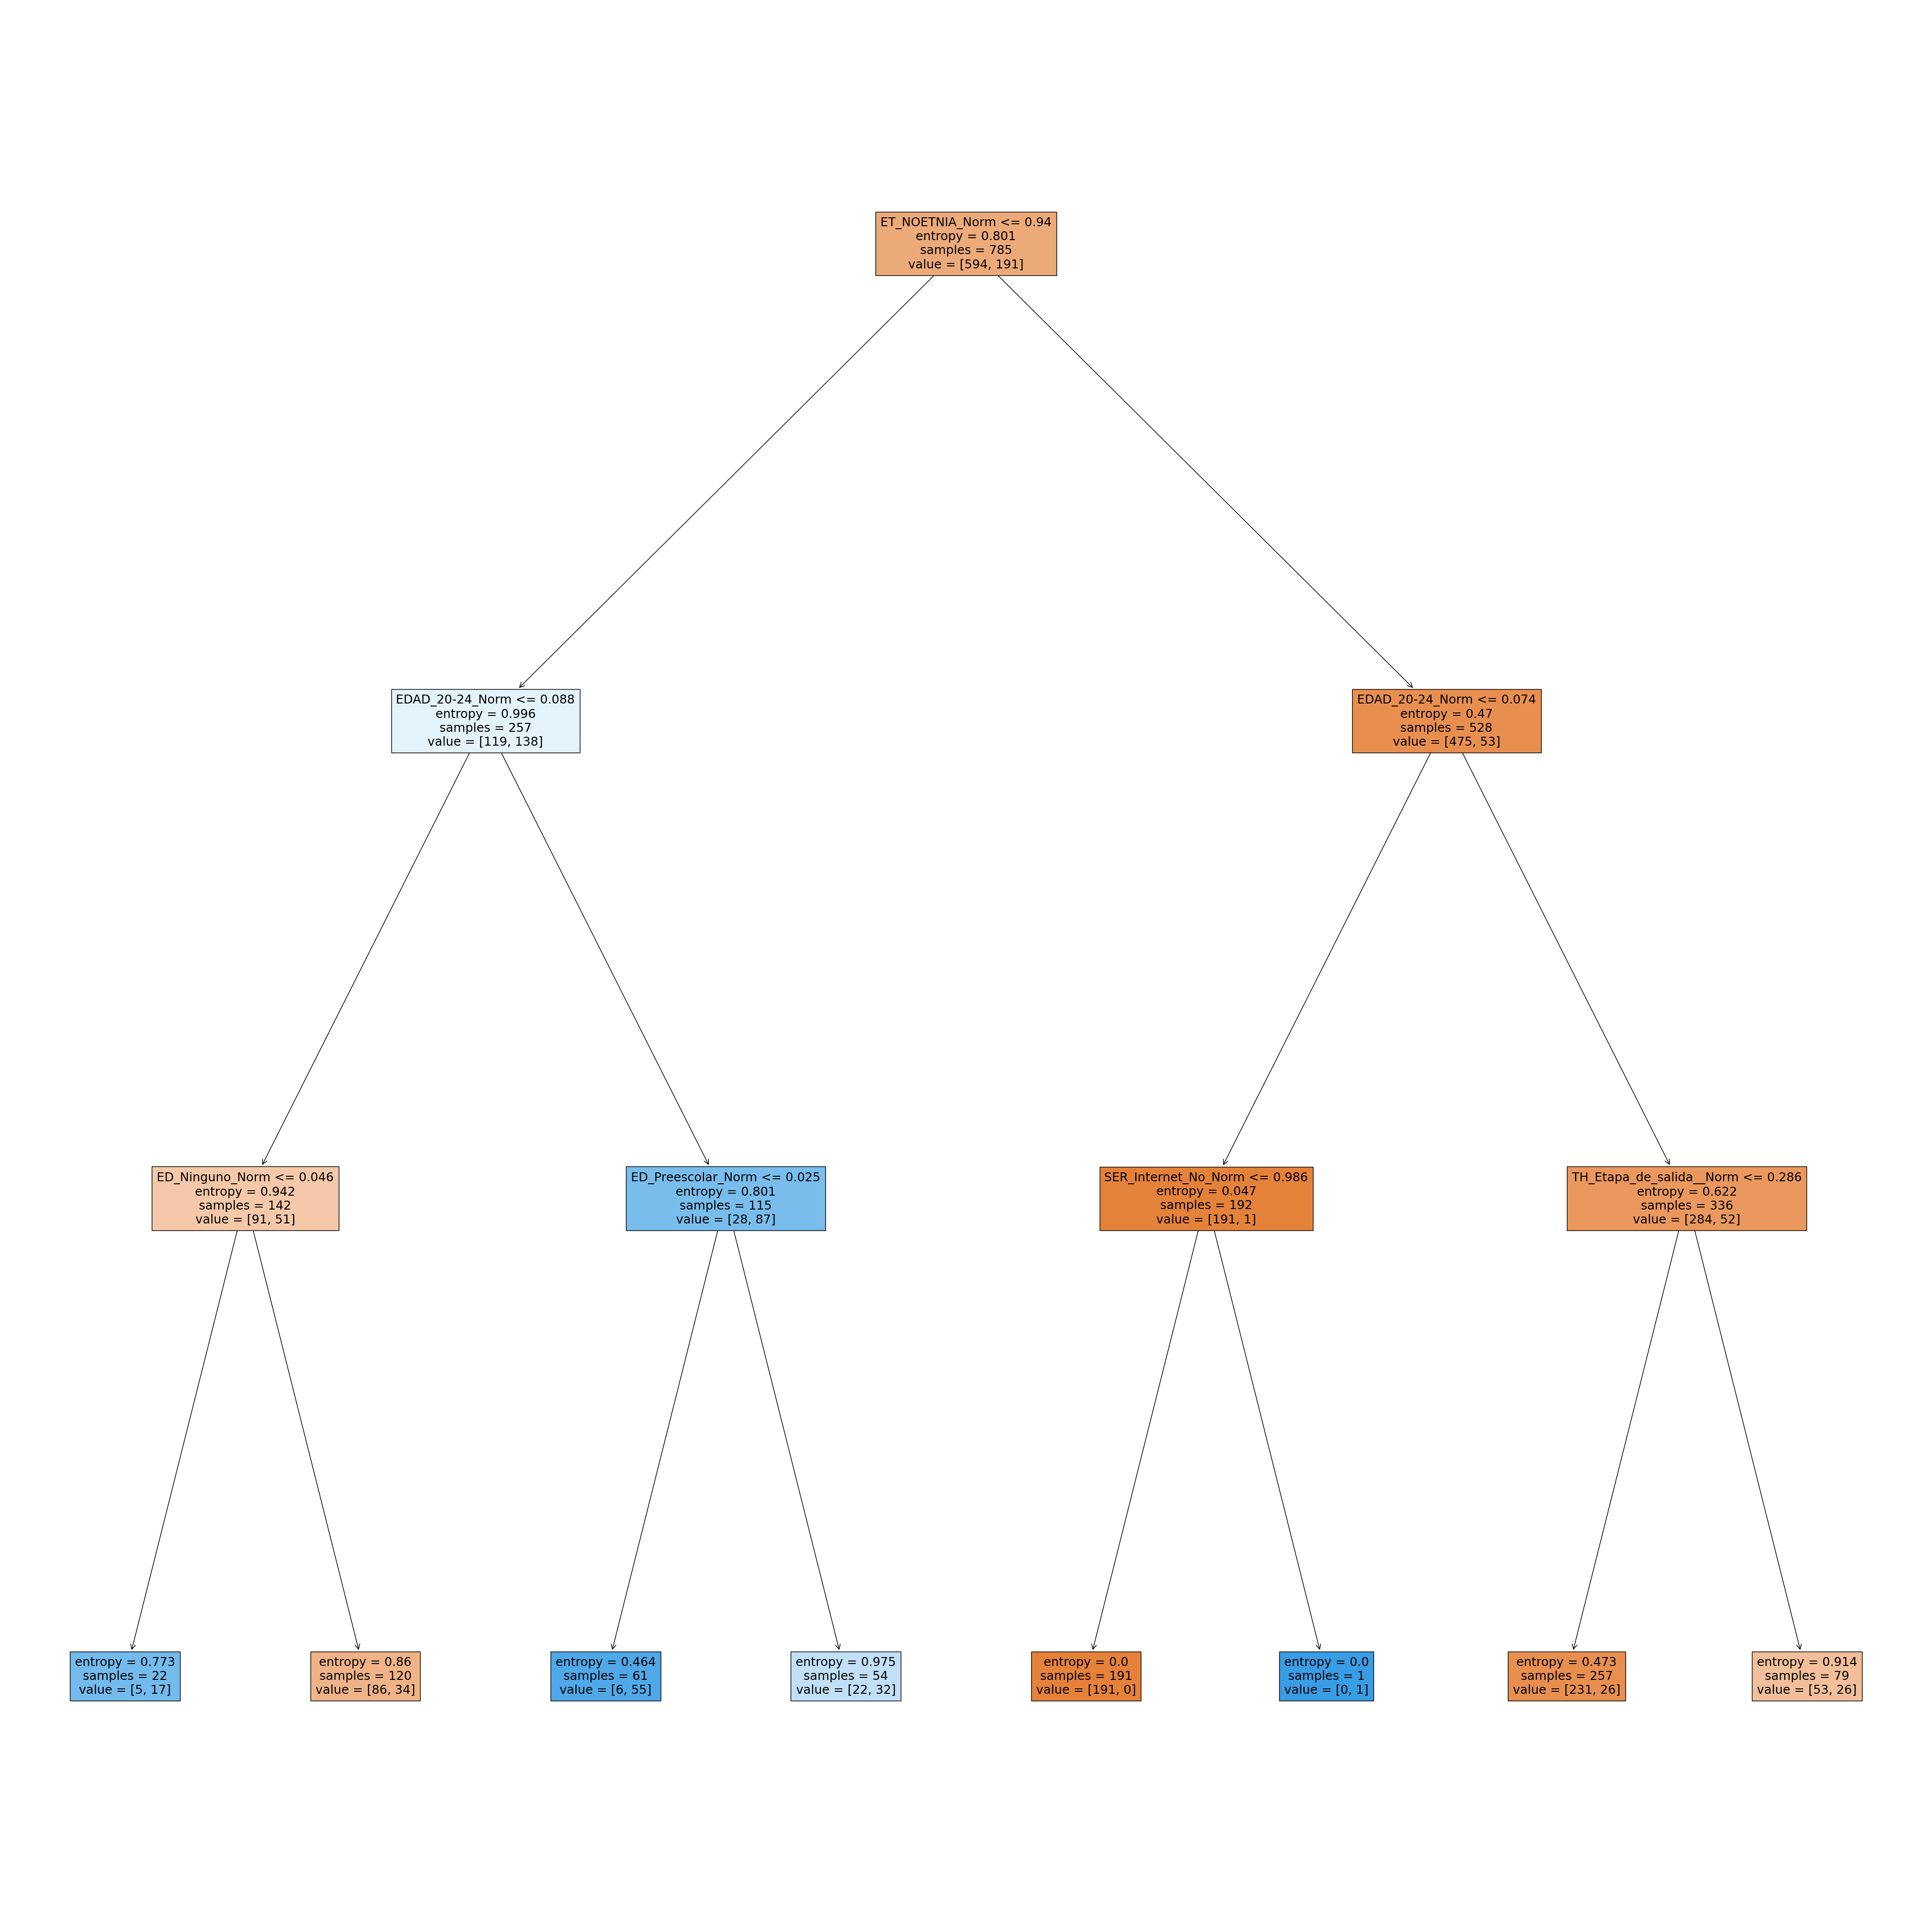


Mejores hiperparámetros: {'max_depth': 3, 'criterion': 'entropy'}
Precisión del modelo con los mejores hiperparámetros: 0.8160237388724035

Importancia de las características:
Feature 0: Importance = 0.5316
Feature 1: Importance = 0.2591
Feature 2: Importance = 0.0000
Feature 3: Importance = 0.0000
Feature 4: Importance = 0.0000
Feature 5: Importance = 0.0000
Feature 6: Importance = 0.0000
Feature 7: Importance = 0.0000
Feature 8: Importance = 0.0000
Feature 9: Importance = 0.0000
Feature 10: Importance = 0.0000
Feature 11: Importance = 0.0000
Feature 12: Importance = 0.0000
Feature 13: Importance = 0.0000
Feature 14: Importance = 0.0000
Feature 15: Importance = 0.0000
Feature 16: Importance = 0.0650
Feature 17: Importance = 0.0000
Feature 18: Importance = 0.0000
Feature 19: Importance = 0.0000
Feature 20: Importance = 0.0000
Feature 21: Importance = 0.0000
Feature 22: Importance = 0.0000
Feature 23: Importance = 0.0000
Feature 24: Importance = 0.0000
Feature 25: Importance = 0.0000
F

In [57]:
# Define una lista de valores para los hiperparámetros que deseas probar
max_depth_values = [3, 5, 7, 10]
criterion_values = ['gini', 'entropy']

best_accuracy = 0
best_params = {}

for max_depth in max_depth_values:
    for criterion in criterion_values:
        # Crea un modelo de árbol de decisión con los hiperparámetros actuales
        clf = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
        
        # Realiza una validación cruzada para evaluar el modelo
        scores = cross_val_score(clf, x_train, y_train, cv=5)  # Puedes ajustar el número de particiones en la validación cruzada
        mean_accuracy = np.mean(scores)
        
        print(f"max_depth={max_depth}, criterion={criterion}: Mean Accuracy = {mean_accuracy}")
        
        # Si encontramos una combinación de hiperparámetros que tiene mejor precisión, la almacenamos
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_params = {'max_depth': max_depth, 'criterion': criterion}
            
# Entrenamos el modelo final con los mejores hiperparámetros en los datos de entrenamiento
best_clf = DecisionTreeClassifier(max_depth=best_params['max_depth'], criterion=best_params['criterion'])
best_clf.fit(x_train, y_train)

# Visualiza el árbol de decisión
plt.figure(figsize=(50, 50))
plot_tree(best_clf, feature_names=features.tolist(), filled=True)

# Muestra la imagen en una ventana emergente en el navegador
plt.show()

# Realizamos predicciones en el conjunto de prueba con el mejor modelo
y_pred = best_clf.predict(x_test)

# Calculamos la precisión del modelo con los mejores hiperparámetros
accuracy = accuracy_score(y_test, y_pred)
print("\nMejores hiperparámetros:", best_params)
print("Precisión del modelo con los mejores hiperparámetros:", accuracy)

# Obtenemos la importancia de las características del mejor modelo
feature_importance = best_clf.feature_importances_

# Imprimimos la importancia de las características
print("\nImportancia de las características:")
for feature, importance in enumerate(feature_importance):
    print(f"Feature {feature}: Importance = {importance:.4f}")


In [58]:
predictions = best_clf.predict(x_test)

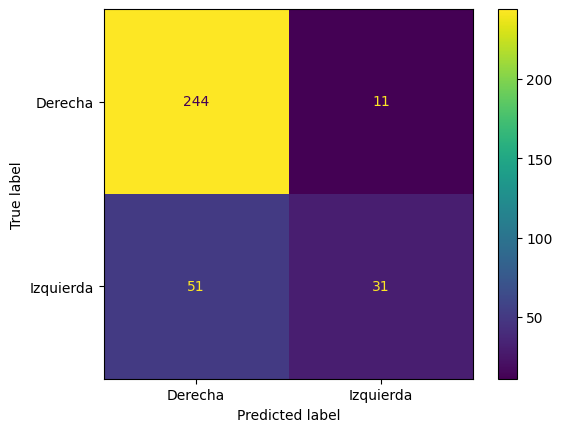

In [59]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions)

In [60]:
features = df_data_x
features

,ET_NOETNIA_Norm,EDAD_20-24_Norm,EST_Viudo_Norm,ET_Indigena_Norm,TH_Pareja_mayor_sin_hijos_Norm,EDAD_55-59_Norm,ED_Primaria_Completa_Norm,EDAD_50-54_Norm,EDAD_25-29_Norm,EDAD_60_o_mas,...,ED_Postgrado_Norm,SER_Internet_No_Norm,ALF_No_Sabe_Leer_Norm,ED_Media_Completa_Norm,ET_Raizal_Norm,ED_Ordinaria_Completa_Norm,ED_Preescolar_Norm,ED_Ninguno_Norm,SAN_Inodoro-pozo_septico_Norm,ED_Universitario_Norm
0,0.9618,0.0956,0.0462,0.0008,0.0971,0.0599,0.1056,0.0664,0.0939,0.1538,...,0.0366,0.3297,0.0232,0.2483,0.0001,0.0010,0.0177,0.0242,0.0224,0.1247
1,0.9903,0.0700,0.0513,0.0001,0.1682,0.0626,0.1613,0.0644,0.0616,0.1896,...,0.0089,0.8071,0.1009,0.1055,0.0000,0.0030,0.0190,0.0738,0.3439,0.0182
2,0.9752,0.0815,0.0460,0.0000,0.1651,0.0584,0.1445,0.0709,0.0579,0.1664,...,0.0113,0.8930,0.0698,0.1815,0.0000,0.0054,0.0153,0.0488,0.1477,0.0286
3,0.9890,0.0685,0.0606,0.0000,0.1741,0.0615,0.1171,0.0667,0.0667,0.1777,...,0.0078,0.8592,0.0852,0.1322,0.0000,0.0017,0.0326,0.0463,0.3851,0.0312
4,0.9920,0.0865,0.0512,0.0003,0.1304,0.0634,0.1498,0.0710,0.0852,0.1492,...,0.0075,0.7491,0.0754,0.2052,0.0000,0.0047,0.0178,0.0552,0.0644,0.0312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,0.0123,0.0489,0.0305,0.9189,0.0417,0.0106,0.1226,0.0225,0.0278,0.0463,...,0.0000,0.8065,0.0909,0.0696,0.0000,0.0028,0.0543,0.0237,0.3548,0.0042
1118,0.6857,0.1020,0.0207,0.2866,0.0906,0.0326,0.0967,0.0402,0.0854,0.0666,...,0.0215,0.8566,0.1021,0.1541,0.0001,0.0051,0.0284,0.1089,0.7540,0.0583
1119,0.7536,0.0859,0.0246,0.2291,0.1005,0.0306,0.1334,0.0442,0.0713,0.0707,...,0.0093,0.9637,0.0789,0.1934,0.0000,0.0014,0.0296,0.0732,0.8900,0.0397
1120,0.1055,0.0920,0.0213,0.8441,0.0599,0.0254,0.1291,0.0309,0.0682,0.0441,...,0.0021,0.9489,0.1403,0.0620,0.0001,0.0023,0.0304,0.1074,0.1488,0.0081


In [61]:
a = y_test.values

In [62]:
precision_score(a, predictions,pos_label="Izquierda")

0.7380952380952381

In [63]:
precision_score(a, predictions,pos_label="Derecha")

0.8271186440677966

In [64]:
# Calculating confusion matrix derived metrics
print("Precision:", precision_score(a, predictions,pos_label="Izquierda"))
print("Recall:", recall_score(a, predictions,pos_label="Izquierda"))
print("F1", f1_score(a, predictions,pos_label="Izquierda"))

Precision: 0.7380952380952381
Recall: 0.3780487804878049
F1 0.5000000000000001


In [65]:
# Calculating confusion matrix derived metrics
print("Precision:", precision_score(a, predictions,pos_label="Derecha"))
print("Recall:", recall_score(a, predictions,pos_label="Derecha"))
print("F1", f1_score(a, predictions,pos_label="Derecha"))

Precision: 0.8271186440677966
Recall: 0.9568627450980393
F1 0.8872727272727272
